# **Tutorial: PINN simulation with JINNAX**

In this tutorial, we present the main features of the JINNAX package for simulating Physics Informed Neural Networks (PINN) in JAX. The purpose of JINNAX is to simulate the training of PINN to approximate the solution of the PDE

\begin{align*}
  \mathcal{N}_{x,t}[u(x,t)] &= f(x,t), \ \ x \in \Omega, \ t \in (t_{l},t_{u}] \\
  u(x,t) &= g(x,t), \ \ x \in \partial \Omega, \ t \in (t_{l},t_{u}]\\
  u(x,t_{l}) &= h(x)\ \ \ , \ \ x \in \bar{\Omega}
\end{align*}

in which $\mathcal{N}_{x,t}$ is a spatial-temporal differential operator, and $\Omega = (x_{l},x_{u})^{d}$ for $d \geq 1$ is the open d-dimensional cube.

The simulation pipeline in JINNAX has three steps:

1.   **Data generation**: Generate data in $\bar{\Omega} \times [t_{l},t_{u}]$
2.   **Training**: Train a PINN with the generated data
3.   **Evaluation**: Evaluate the trained PINN

This tutorial will cover how these steps can be performed with JINNAX. The documentation of JINNAX is available [here](https://raw.githack.com/dmarcondes/JINNAX/master/docs/jinnax.html).


### **Import JINNAX**

The latest version of JINNAX can be imported from Github. It has `data` and `nn` modules.

In [1]:
#Install genree, jinnax and dill
import os
os.system("pip3 install dill") #For saving results
os.system("pip3 install --upgrade git+https://github.com/dmarcondes/genree") #For error estimation
os.system("pip3 install --upgrade git+https://github.com/dmarcondes/JINNAX")

#Import jinnax
from jinnax import data as jd
from jinnax import nn as nn

### **Step 1: Data generation**

Data is generated by sensors placed in $\bar{\Omega}$ which realize measures over time, as follows:

*  **Sensor data**: There are $N_{s}^{d}, N_{s} > 1,$ sensors in $\Omega$, placed either in a grid or in uniformly sampled positions. These sensors provide measures at $N_{ts}$ times in a grid of $(t_{l},t_{u}]$ or at $N_{ts}$ times uniformly sampled from $(t_{l},t_{u}]$. The sensors have a mean-zero Gaussian noise with variance $\sigma_{s}^{2} \geq 0$. The sensor points are of form
$$\left(x_{i}^{(s)},t_{j}^{(s)},u(x_{i}^{(s)},t_{j}^{(s)})) + \epsilon_{i,j}^{(s)}\right), \ i = 1,\dots,N_{s}^{d}, j = 1, \dots, N_{ts}$$
in which $\epsilon_{i,j}^{(s)} \sim N(0,\sigma_{s}^{2})$ are independet random variables.

* **Initial data**: There are $N_{0}$ initial points (with $t = t_{l}$) in a grid of $\bar{\Omega}$ or uniformly sampled from this set. The sensors have a mean-zero Gaussian noise with variance $\sigma_{0}^{2} \geq 0$. The initial points are of form
$$\left(x_{i}^{(0)},t_{l},h(x_{i}) + \epsilon_{i}^{(0)}\right), \ i = 1,\dots,N_{0}$$
in which $\epsilon_{i}^{(0)} \sim N(0,\sigma_{0}^{2})$ are independet random variables.

* **Boundary data**: Observe that $\partial \Omega$ is formed by the edges of the n-cube $\bar{\Omega}$. In each edge of the n-cube $\bar{\Omega}$ there are $N_{b}$ sensor in either a grid or in uniformly sampled positions. These sensors provide measures at $N_{tb}$ times in a grid of $(t_{l},t_{u}]$ or at $N_{tb}$ times uniformly sampled from $(t_{l},t_{u}]$. Hence, there are $2N_{tb}$ boundary points if $d = 1$ and
$$N_{tb} \sum_{i=1}^{d} \binom{d}{i} 2^{i} N_{b}^{d-i} =  N_{tb} \left((N _{b} + 2)^{d} - N_{b}^{d}\right) $$
boundary points when $d > 1$. The sensors have a mean-zero Gaussian noise with variance $\sigma_{b}^{2} \geq 0$. The boundary points are of form
$$\left(x_{i}^{(b)},t_{j}^{(b)},g(x_{i}^{(b)},t_{j}^{(b)})) + \epsilon_{i,j}^{(b)}\right), \ i = 1,\dots,(N _{b} + 2)^{d} - N_{b}^{d}, j = 1, \dots, N_{tb}$$
in which $\epsilon_{i,j}^{(b)} \sim N(0,\sigma_{b}^{2})$ are independet random variables.

* **Collocation points**: There are $N_{c}^{d}$ collocation points in $\Omega$ placed either in a grid or in uniformly sampled positions. These spatial points are considered in $N_{ct}$ times in a grid of $(t_{l},t_{u}]$ or uniformly sampled from this set. The collocation points are of form
$$\left(x_{i}^{(c)},t_{j}^{(c)}\right), \ i = 1,\dots,N _{c}, j = 1, \dots, N_{tc}$$

Observe that in all types of data, the spatial and temporal points are selected independently and the data is actually the Cartesean product of the selected points. When $\sigma_{s}^{2} = 0, \sigma_{0}^{2} = 0$ or $\sigma_{b}^{2} = 0$, the respective data does not have noise. If $N_{s}N_{ts} = 0, N_{0} = 0, N_{tb} = 0$ or $N_{c}N_{tc} = 0$ then, respectively, no sensor, initial, boundary or collocation data is considered.

#### **JINNAX funtion for data generation**

Simulation data is generated by the function `generate_PINNdata` from the `data` module. Its documentation can be found [here](https://raw.githack.com/dmarcondes/JINNAX/master/docs/jinnax/data.html#generate_PINNdata). The code below presents examples of data generated for one and two dimensional domains.

In [2]:
#One dimensional sensor data in a grid
u = lambda x,t: x*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Ns = 3,Nts = 2,d = 1,poss = 'grid',posts = 'grid')
print(data['sensor'])

[[0.25 0.5 ]
 [0.25 1.  ]
 [0.5  0.5 ]
 [0.5  1.  ]
 [0.75 0.5 ]
 [0.75 1.  ]]


In [3]:
#Two dimensional sensor data in a grid
u = lambda x,t: x[0] + x[1]*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Ns = 3,Nts = 2,d = 2,poss = 'grid',posts = 'grid')
print(data['sensor'])

[[0.25 0.25 0.5 ]
 [0.25 0.25 1.  ]
 [0.25 0.5  0.5 ]
 [0.25 0.5  1.  ]
 [0.25 0.75 0.5 ]
 [0.25 0.75 1.  ]
 [0.5  0.25 0.5 ]
 [0.5  0.25 1.  ]
 [0.5  0.5  0.5 ]
 [0.5  0.5  1.  ]
 [0.5  0.75 0.5 ]
 [0.5  0.75 1.  ]
 [0.75 0.25 0.5 ]
 [0.75 0.25 1.  ]
 [0.75 0.5  0.5 ]
 [0.75 0.5  1.  ]
 [0.75 0.75 0.5 ]
 [0.75 0.75 1.  ]]


In [4]:
#One dimensional boundary data
u = lambda x,t: x*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Nb = 0,Ntb = 3,d = 1)
print(data['boundary'])

[[0.         0.33333334]
 [0.         0.6666667 ]
 [0.         1.        ]
 [1.         0.33333334]
 [1.         0.6666667 ]
 [1.         1.        ]]


In [5]:
#Two dimensional boundary data in a grid
u = lambda x,t: x[0] + x[1]*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Nb = 2,Ntb = 2,d = 2,posb = 'grid',postb = 'grid')
print(data['boundary'])

[[0.         0.         0.5       ]
 [0.         0.         1.        ]
 [0.         1.         0.5       ]
 [0.         1.         1.        ]
 [0.         0.33333334 0.5       ]
 [0.         0.33333334 1.        ]
 [0.         0.6666667  0.5       ]
 [0.         0.6666667  1.        ]
 [1.         0.         0.5       ]
 [1.         0.         1.        ]
 [1.         1.         0.5       ]
 [1.         1.         1.        ]
 [1.         0.33333334 0.5       ]
 [1.         0.33333334 1.        ]
 [1.         0.6666667  0.5       ]
 [1.         0.6666667  1.        ]
 [0.33333334 0.         0.5       ]
 [0.33333334 0.         1.        ]
 [0.6666667  0.         0.5       ]
 [0.6666667  0.         1.        ]
 [0.33333334 1.         0.5       ]
 [0.33333334 1.         1.        ]
 [0.6666667  1.         0.5       ]
 [0.6666667  1.         1.        ]]


In [6]:
#One dimensional initial data in a grid
u = lambda x,t: x*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,N0 = 10,d = 1,pos0 = 'grid')
print(data['initial'])

[[0.         0.        ]
 [0.11111111 0.        ]
 [0.22222222 0.        ]
 [0.33333334 0.        ]
 [0.44444445 0.        ]
 [0.5555556  0.        ]
 [0.6666667  0.        ]
 [0.7777778  0.        ]
 [0.8888889  0.        ]
 [1.         0.        ]]


In [7]:
#Two dimensional initial data in a grid
u = lambda x,t: x[0] + x[1]*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,N0 = 3,d = 2,pos0 = 'grid')
print(data['initial'])

[[0.  0.  0. ]
 [0.  0.5 0. ]
 [0.  1.  0. ]
 [0.5 0.  0. ]
 [0.5 0.5 0. ]
 [0.5 1.  0. ]
 [1.  0.  0. ]
 [1.  0.5 0. ]
 [1.  1.  0. ]]


In [8]:
#One dimensional collocation data in a grid
u = lambda x,t: x*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Nc = 3,Ntc = 3,d = 1,posc = 'grid')
print(data['collocation'])

[[0.25       0.33333334]
 [0.25       0.6666667 ]
 [0.25       1.        ]
 [0.5        0.33333334]
 [0.5        0.6666667 ]
 [0.5        1.        ]
 [0.75       0.33333334]
 [0.75       0.6666667 ]
 [0.75       1.        ]]


In [9]:
#Two dimensional collocation data in a grid
u = lambda x,t: x[0] + x[1]*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Nc = 3,Ntc = 2,d = 2,posc = 'grid')
print(data['collocation'])

[[0.25 0.25 0.5 ]
 [0.25 0.25 1.  ]
 [0.25 0.5  0.5 ]
 [0.25 0.5  1.  ]
 [0.25 0.75 0.5 ]
 [0.25 0.75 1.  ]
 [0.5  0.25 0.5 ]
 [0.5  0.25 1.  ]
 [0.5  0.5  0.5 ]
 [0.5  0.5  1.  ]
 [0.5  0.75 0.5 ]
 [0.5  0.75 1.  ]
 [0.75 0.25 0.5 ]
 [0.75 0.25 1.  ]
 [0.75 0.5  0.5 ]
 [0.75 0.5  1.  ]
 [0.75 0.75 0.5 ]
 [0.75 0.75 1.  ]]


### **Step 2: Training the PINN**

A PINN is trained with the function `train_PINN` of the `nn` module. A fully connected architecture initialized with Glorot initialization is considered. The usual sum of the mean square error on sensor, boundary, initial and collocation points is considered as the loss function to be minimized:

$$\mathcal{L}(\boldsymbol{w}) = \mathcal{L}_{s}(\boldsymbol{w}) + \mathcal{L}_{b}(\boldsymbol{w}) + \mathcal{L}_{0}(\boldsymbol{w}) + \mathcal{L}_{c}(\boldsymbol{w})$$
in which
\begin{align*}
  \mathcal{L}_{s}(\boldsymbol{w}) =& \frac{1}{N_{s} N_{ts}} \sum_{i = 1}^{N_{ts}} \sum_{j = 1}^{N_{s}} \left|y_{i,j}^{(s)} - u_{\boldsymbol{w}}(x_{i}^{(s)},t_{j}^{(s)}) \right|^{2} \\
  \mathcal{L}_{b}(\boldsymbol{w}) =& \frac{1}{K N_{tb}} \sum_{i = 1}^{N_{tb}} \sum_{j = 1}^{K} \left|y_{i,j}^{(b)} - u_{\boldsymbol{w}}(x_{i}^{(b)},t_{j}^{(b)}) \right|^{2} \\
  \mathcal{L}_{0}(\boldsymbol{w}) =& \frac{1}{N_{0}} \sum_{j = 1}^{N_{0}} \left|y_{j}^{(0)} - u_{\boldsymbol{w}}(x_{i}^{(0)},0) \right|^{2} \\
  \mathcal{L}_{c}(\boldsymbol{w}) =& \frac{1}{N_{c} N_{tc}} \sum_{i = 1}^{N_{tc}} \sum_{j = 1}^{N_{c}} \left|\mathcal{N}_{x_{i}^{(c)},t_{j}^{(c)}}[u_{\boldsymbol{w}}(x_{i}^{(c)},t_{j}^{(c)})] - f(x_{i}^{(c)},t_{j}^{(c)})\right|^{2}
\end{align*}
where $u_{\boldsymbol{w}}$ is the fuction realized by the neural network with parameters $\boldsymbol{w}$ and $K = (N _{b} + 2)^{d} - N_{b}^{d}$ is the number of spatial boundary points. The $y$ points above are defined as

\begin{align*}
  y_{i,j}^{(s)} &= u(x_{i},t_{j}) + \epsilon_{i,j}^{(s)}\\
  y_{i,j}^{(b)} &= g(x_{i},t_{j}) + \epsilon_{i,j}^{(b)}\\
  y_{i}^{(0)} &= h(x_{i}) + \epsilon_{i}^{(0)}
\end{align*}
The L2 error on test data can be evaluated during and after training. The exact and predicted solution can be plotted for `d = 1`.

The documentation of the `train_PINN`function can be found [here](https://raw.githack.com/dmarcondes/JINNAX/master/docs/jinnax/nn.html#train_PIIN).


### **Example 1: Viscous Burgers**

We will exemplify training PINN in JINNAX with the Viscous Burgers equation nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions:

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in (-1,1) \times (0,1]\,,\\
  &u(1,t) = u(-1,t) = 0\,, \quad t \in (0,1]\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad x \in [-1,1]\,, \\
  \end{aligned}

where $\nu>0$ is the kinematic viscosity.

We start by computing the explicit solution and generating data. More details about this implementation may be found at the [SciML Course of the Scientific Machine Learning Lab - TAMIDS Texas A&M](https://colab.research.google.com/drive/1qBrbgevkSBqqYc8bOPiaoJG1MBrBrluN?usp=share_link).

In [10]:
#Import
import jax
from jax import numpy as jnp
from numpy.polynomial.hermite import hermgauss
import numpy as np

#Parameters of the simulation
nu = 0.01/np.pi # viscosity parameter
qn = 64 # order of quadrature rule
qx,qw = hermgauss(qn)

#Domain
xl = -1.0
xu = +1.0
tl = 0.0
tu = 1.0

#Compute analytical solution u(x,t)
def u(x,t):
  u = 0
  if (t == 0.0):
    u = -jnp.sin(jnp.pi*x)
  else:
    top = 0.0
    bot = 0.0
    for qj in range(qn):
      c = 2.0*jnp.sqrt(nu*t)
      top = top - qw[qj]*c*jnp.sin(jnp.pi*(x - c*qx[qj]))*jnp.exp(-jnp.cos(jnp.pi*(x-c*qx[qj]))/(2.0*jnp.pi*nu))
      bot = bot + qw[qj]*c*jnp.exp(-jnp.cos(jnp.pi*(x - c*qx[qj]))/(2.0*jnp.pi*nu))
    u = top/bot
  return u

#PDE in the form pde(u,x,t) = 0
def pde(u,x,t):
    ux = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),0)(x,t)
    ut = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),1)(x,t)
    uxx = lambda x,t : jax.grad(lambda x,t : jnp.sum(ux(x,t)),0)(x,t)
    return ut(x,t) + u(x,t)*ux(x,t) - nu*uxx(x,t)

#Generate deterministic trainig data in a grid
train_data = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 10,Nts = 10,Nb = 10,Ntb = 10,N0 = 10,Nc = 10,Ntc = 10)
#Generate test data
test_data = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 20,Nts = 20,train = False)

In [11]:
#Sample sizes
print('Sensor data: ' + str(train_data['sensor'].shape[0]))
print('Initial data: ' + str(train_data['initial'].shape[0]))
print('Boundary data: ' + str(train_data['boundary'].shape[0]))
print('Collocation data: ' + str(train_data['collocation'].shape[0]))

Sensor data: 100
Initial data: 10
Boundary data: 20
Collocation data: 100


A PINN for the Viscous Burgers equation will be trained for 20,000 epochs. We consider a fully connected neural networks with an input layer of width 2, followed by 8 layers with width 20 and an output layer with width 1. The L2 error in a grid of 400 points will be calculated every 1,000 epochs.

In [12]:
#Train
width = [2] + 8*[20] + [1]
fit = nn.train_PINN(data = train_data,width = width,pde = pde,test_data = test_data,epochs = 20000,epoch_print = 1000)

on 0: Time: 4 s Loss: 4.845577 L2 error: 2.139706
on 1000: Time: 6 s Loss: 0.091769 L2 error: 0.439874
on 2000: Time: 7 s Loss: 0.077144 L2 error: 0.428625
on 3000: Time: 9 s Loss: 0.024171 L2 error: 0.332685
on 4000: Time: 11 s Loss: 0.001346 L2 error: 0.105141
on 5000: Time: 13 s Loss: 0.001373 L2 error: 0.087735
on 6000: Time: 14 s Loss: 0.00026 L2 error: 0.071912
on 7000: Time: 16 s Loss: 0.000176 L2 error: 0.063051
on 8000: Time: 17 s Loss: 0.00023599999 L2 error: 0.055138
on 9000: Time: 19 s Loss: 0.000105 L2 error: 0.050155
on 10000: Time: 20 s Loss: 8.5e-05 L2 error: 0.04592
on 11000: Time: 22 s Loss: 0.000787 L2 error: 0.047613
on 12000: Time: 24 s Loss: 8.7e-05 L2 error: 0.039394
on 13000: Time: 25 s Loss: 2.6e-05 L2 error: 0.034787
on 14000: Time: 27 s Loss: 0.000101 L2 error: 0.030077
on 15000: Time: 28 s Loss: 9.3e-05 L2 error: 0.028985
on 16000: Time: 30 s Loss: 6.5e-05 L2 error: 0.025966
on 17000: Time: 31 s Loss: 6.2e-05 L2 error: 0.024084
on 18000: Time: 33 s Loss: 9e-

### **Step 3: Evaluate results**

The results of a trained PINN are evaluated in `jinnax` by the function `process_result` of the `nn` module. For `d > 1`, this function only computes the L2 error. For `d = 1`, it is possible to plot the predicted and exact solution for a sequence of times in the time interval and a 2D plot of the predicted and exact solutions.

The documentation of `process_result` is available [here](https://raw.githack.com/dmarcondes/JINNAX/master/docs/jinnax/nn.html#process_result).

L2 error test: 0.020229 L2 error train: 0.008341 MSE error test: 0.000148 MSE error train: 2.4e-05


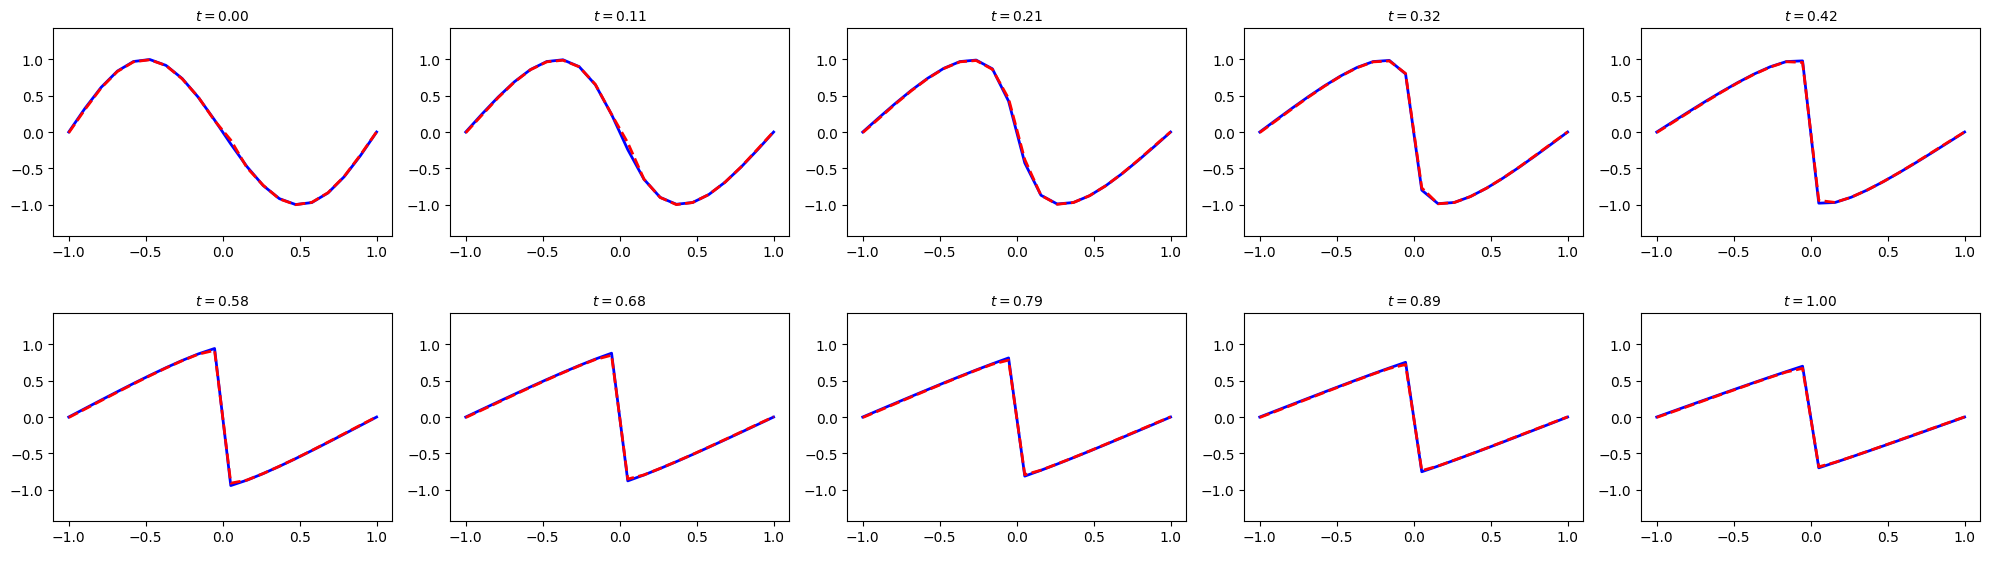

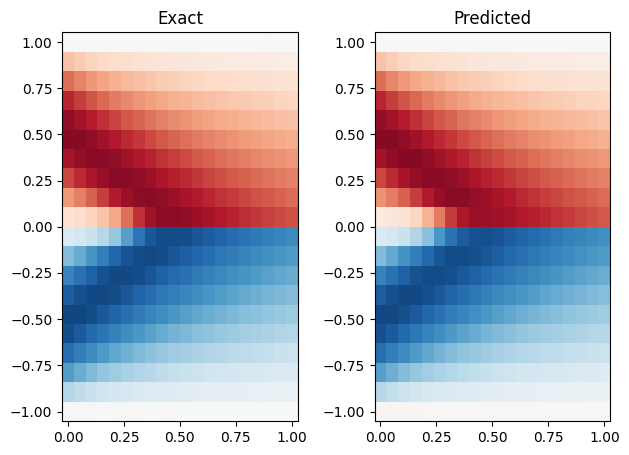

,l2_error_test,MSE_test,l2_error_train,MSE_train
0,0.020229,0.000148,0.008341,0.000024


In [14]:
#Process results Viscous Burgers
nn.process_result(test_data,fit['u'],train_data,times = 10)

### **Example 2: Advection Problem**

We will exemplify training PINN in JINNAX with the following Advection Problem:

  \begin{aligned}
  &u_t + \nu \ u_x = 0\,, \quad (x,t) \in (0,2\pi) \times (0,1]\,,\\
    &u(-1,t) = \sin(-1 - 50t)\,, \quad t \in (0,1]\,,\\
    &u(1,t) = \sin(1 - 50t)\,, \quad t \in (0,1]\,,\\
     &u(x,0) = \sin(x)\,, \quad x \in [0,2\pi]\,, \\
  \end{aligned}
for $\nu > 0$, whose solution is $u(x,t) = \sin(x - \nu t)$.

In [15]:
#Parameters of the simulation
L =  2*np.pi
T = 1.0
v = 50.0

#Domain
xl = 0
xu = L
tl = 0.0
tu = T

#Compute analystical solution u(x,t)
def u(x,t):
    u = jnp.sin(x - v*t)
    return u

#PDE
def pde2(u,x,t):
  ux = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),0)(x,t)
  ut = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),1)(x,t)
  return ut(x,t) + v*ux(x,t)

#Generate train and test data
train_data2 = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 100,Nts = 100,Nb = 100,Ntb = 100,N0 = 100,Nc = 100,Ntc = 100)
test_data2 = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 100,Nts = 100,train = False)

In [16]:
#Sample sizes
print('Sensor data: ' + str(train_data2['sensor'].shape[0]))
print('Initial data: ' + str(train_data2['initial'].shape[0]))
print('Boundary data: ' + str(train_data2['boundary'].shape[0]))
print('Collocation data: ' + str(train_data2['collocation'].shape[0]))

Sensor data: 10000
Initial data: 100
Boundary data: 200
Collocation data: 10000


In [17]:
#Train a PINN for 50000 epochs
width2 = [2] + 8 * [20] + [1]
fit2 = nn.train_PINN(data = train_data2,width = width2,pde = pde2,test_data = test_data2,epochs = 50000,epoch_print = 1000)

on 0: Time: 3 s Loss: 12.004267 L2 error: 2.12642
on 1000: Time: 6 s Loss: 1.489432 L2 error: 1.000723
on 2000: Time: 9 s Loss: 1.477291 L2 error: 1.001942
on 3000: Time: 13 s Loss: 0.874615 L2 error: 0.928253
on 4000: Time: 16 s Loss: 0.722639 L2 error: 0.842631
on 5000: Time: 20 s Loss: 0.606691 L2 error: 0.76686
on 6000: Time: 23 s Loss: 0.521561 L2 error: 0.714021
on 7000: Time: 26 s Loss: 0.44124 L2 error: 0.638606
on 8000: Time: 29 s Loss: 0.33052 L2 error: 0.56566
on 9000: Time: 33 s Loss: 0.364062 L2 error: 0.55781597
on 10000: Time: 36 s Loss: 0.268193 L2 error: 0.515779
on 11000: Time: 39 s Loss: 0.319794 L2 error: 0.503415
on 12000: Time: 43 s Loss: 0.17316 L2 error: 0.419004
on 13000: Time: 46 s Loss: 0.145891 L2 error: 0.381519
on 14000: Time: 49 s Loss: 0.145542 L2 error: 0.365414
on 15000: Time: 52 s Loss: 0.134363 L2 error: 0.359845
on 16000: Time: 56 s Loss: 0.130968 L2 error: 0.34017
on 17000: Time: 59 s Loss: 0.082163 L2 error: 0.272602
on 18000: Time: 62 s Loss: 0.0

L2 error test: 0.05756 L2 error train: 0.057556 MSE error test: 0.001657 MSE error train: 0.001656


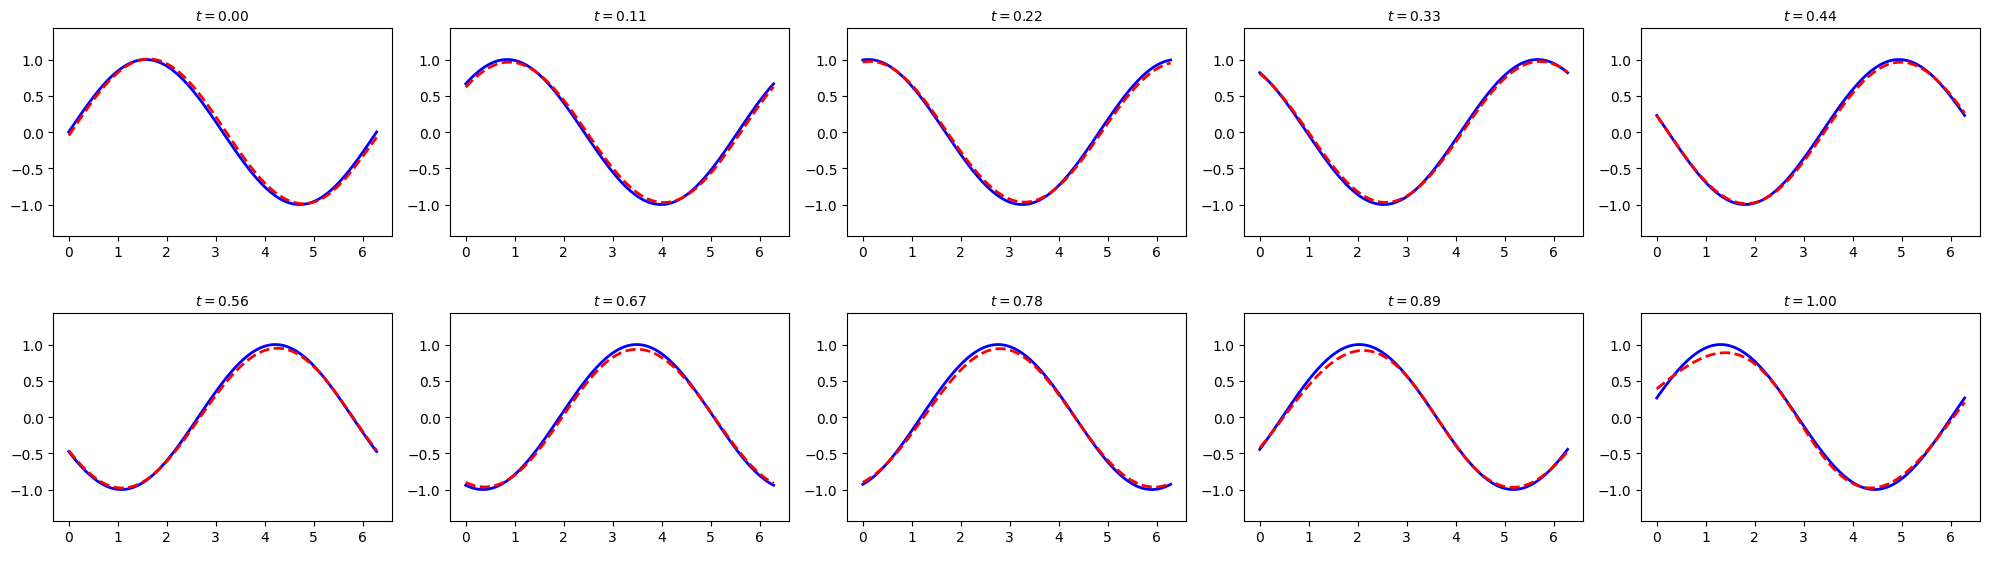

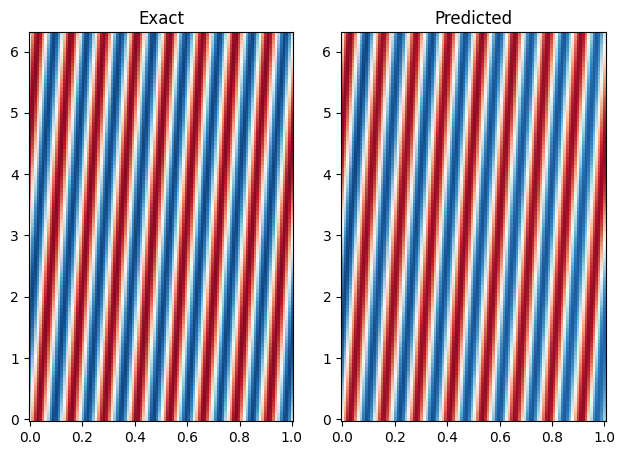

,l2_error_test,MSE_test,l2_error_train,MSE_train
0,0.05756,0.001657,0.057556,0.001656


In [18]:
#Process Result
nn.process_result(test_data2,fit2['u'],train_data2,times = 10)